In [ ]:
import sys
import os
import os.path as osp
import warnings

warnings.filterwarnings("ignore")
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# dirname = osp.dirname(osp.abspath(__file__))
sys.path.append(osp.join(os.getcwd(), 'Main'))

import numpy as np
import time
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.loader import DataLoader

from Main.pargs import pargs
from Main.bert_dataset import BertTreeDataset
from Main.gat_model import ResGAT_graphcl, BiGAT_graphcl
from Main.utils import create_log_dict_sup, write_log, write_json
from Main.augmentation import augment
from Main.sort import sort_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [37]:
dataset = "DRWeiboV3"
centrality = "PageRank"
undirected = True
device = "cuda:7"
bert_cache_dir = osp.join(os.getcwd(), 'cache', 'bert_embeddings')
batch_size = 32
label_source_path = osp.join(os.getcwd(), 'data', dataset, 'source')
label_dataset_path = osp.join(os.getcwd(), 'data', dataset, 'dataset')
train_path = osp.join(label_dataset_path, 'train')
val_path = osp.join(label_dataset_path, 'val')
test_path = osp.join(label_dataset_path, 'test')


In [32]:
train_dataset = BertTreeDataset(
    train_path, 
    bert_model_name='bert-base-chinese', 
    centrality_metric=centrality, 
    undirected=undirected,
    cache_dir=bert_cache_dir,
    device=device,
    dataset=dataset
)


Loading BERT model: bert-base-chinese


BERT embedding dimension: 768


In [58]:
train_dataset[0]

Data(x=[38, 768], edge_index=[2, 74], y=[1], time=[38], no_root_edge_index=[2, 0], centrality=[38])

In [38]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [39]:
for data in train_loader:

    break

In [45]:
data

DataBatch(x=[2171, 768], edge_index=[2, 4276], y=[32], time=[2171], no_root_edge_index=[2, 532], centrality=[2171], batch=[2171], ptr=[33])

In [44]:
data.x.shape

torch.Size([2171, 768])

In [47]:
data.y

tensor([1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 1])

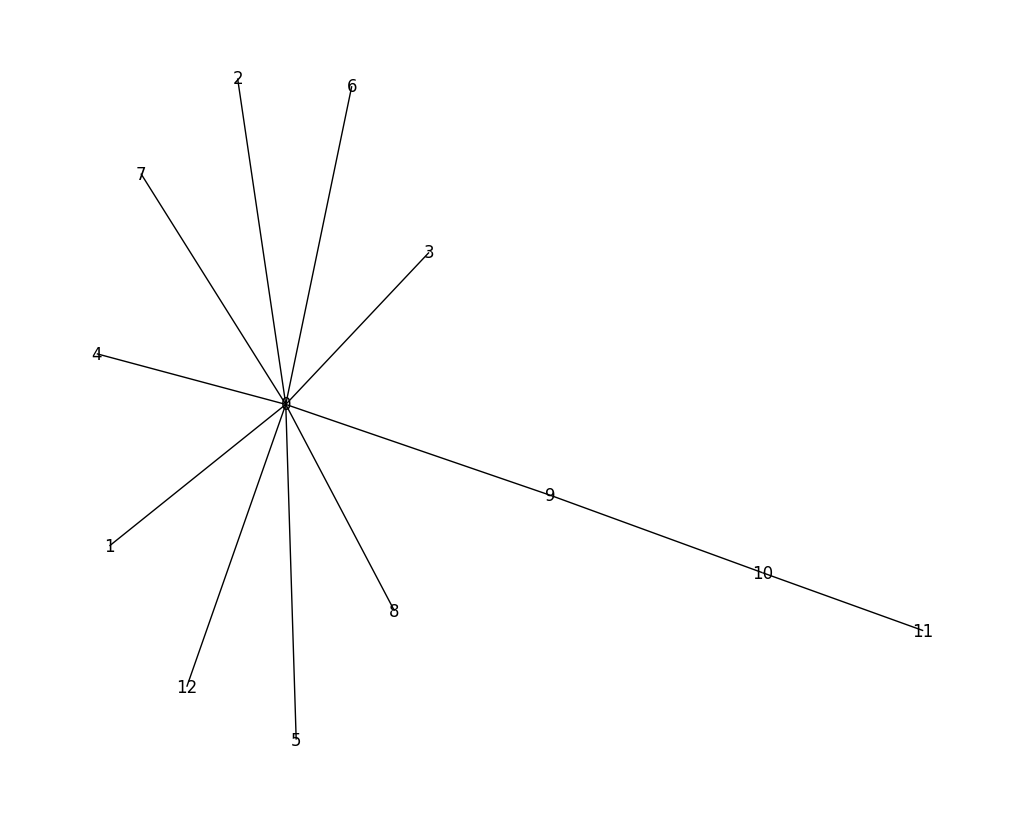

In [34]:
sample_data = train_dataset[1]

G = to_networkx(sample_data, to_undirected=True)

# Add centrality as node attribute
for i, centrality_value in enumerate(sample_data.centrality):
    G.nodes[i]['centrality'] = centrality_value.item()


plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # or nx.kamada_kawai_layout(G) for better tree visualization

# Set node size based on centrality
node_size = [300 * G.nodes[n]['centrality'] for n in G.nodes()]

# Use different colors for different depths
# You'd need to compute depth for each node first

nx.draw(G, pos, with_labels=True, node_size=node_size)
plt.savefig('rumor_tree.png')

In [48]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.utils import to_networkx
import matplotlib.cm as cm

def visualize_rumor_tree_by_level(sample_data, save_path='rumor_tree_by_level.png'):
    """
    Visualize rumor propagation tree with different colors for different level replies.
    
    Args:
        sample_data: A sample from your PyTorch Geometric dataset
        save_path: Path to save the visualization
    """
    # Convert to NetworkX graph
    G = to_networkx(sample_data, to_undirected=True)
    
    # Add centrality as node attribute
    for i, centrality_value in enumerate(sample_data.centrality):
        G.nodes[i]['centrality'] = centrality_value.item()
    
    # Compute node levels (depth in the tree)
    # Assuming node 0 is the root
    root = 0
    
    # Create a BFS to determine node levels
    levels = {root: 0}  # Root is at level 0
    visited = {root}
    current_level = [root]
    
    while current_level:
        next_level = []
        for node in current_level:
            for neighbor in G.neighbors(node):
                if neighbor not in visited:
                    visited.add(neighbor)
                    levels[neighbor] = levels[node] + 1
                    next_level.append(neighbor)
        current_level = next_level
    
    # Add level attribute to each node
    for node in G.nodes():
        G.nodes[node]['level'] = levels.get(node, 0)
    
    # Set up the plot
    plt.figure(figsize=(12, 10))
    plt.title("Rumor Propagation Tree (Colored by Level)", fontsize=16)
    
    # Create a circular layout 
    # For better visualization of tree-like structures, we'll use a modified layout
    if len(G.nodes()) > 1:
        # Root at center, then concentric circles based on level
        pos = {root: (0, 0)}  # Root at center
        
        # Get maximum level
        max_level = max(levels.values())
        
        # Group nodes by level
        nodes_by_level = {}
        for node, level in levels.items():
            if level not in nodes_by_level:
                nodes_by_level[level] = []
            nodes_by_level[level].append(node)
        
        # Position nodes in concentric circles
        for level, nodes in nodes_by_level.items():
            if level == 0:  # Skip root
                continue
                
            # Radius for this level
            radius = level * 3 
            
            # Position nodes in a circle at this radius
            n_nodes = len(nodes)
            for i, node in enumerate(nodes):
                theta = 2 * np.pi * i / n_nodes
                x = radius * np.cos(theta)
                y = radius * np.sin(theta)
                pos[node] = (x, y)
    else:
        # Fallback to spring layout if there's only the root
        pos = nx.spring_layout(G, seed=42)
    
    # Create color map based on levels
    cmap = cm.get_cmap('viridis', max(levels.values()) + 1)
    
    # Get node colors based on levels
    node_colors = [cmap(levels.get(node, 0)) for node in G.nodes()]
    
    # Get node sizes based on centrality
    # Add a minimum size to make all nodes visible
    node_size = [max(300, 1000 * G.nodes[n]['centrality']) for n in G.nodes()]
    
    # Draw nodes with colors based on level
    nx.draw_networkx_nodes(
        G, pos, 
        node_color=node_colors, 
        node_size=node_size,
        edgecolors='white',  # White edge around nodes
        linewidths=1.5,      # Width of the edge
        alpha=0.8            # Transparency
    )
    
    # Draw edges
    nx.draw_networkx_edges(
        G, pos,
        width=1.0,
        alpha=0.5,
        edge_color='gray'
    )
    
    # Draw node labels
    labels = {node: str(node) for node in G.nodes()}
    nx.draw_networkx_labels(
        G, pos,
        labels=labels,
        font_size=10,
        font_color='black',
        font_weight='bold'
    )
    
    # Add color bar to show level mapping
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(levels.values())))
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=range(max(levels.values()) + 1))
    cbar.set_label('Reply Level', fontsize=12)
    
    # Add legend for node sizes
    min_centrality = min(G.nodes[n]['centrality'] for n in G.nodes())
    max_centrality = max(G.nodes[n]['centrality'] for n in G.nodes())
    
    # Create legend elements for node sizes
    size_legend_elements = []
    for c, label in [(min_centrality, 'Min Centrality'), 
                     ((min_centrality + max_centrality)/2, 'Mid Centrality'),
                     (max_centrality, 'Max Centrality')]:
        size = max(300, 1000 * c)
        size_legend_elements.append(
            plt.scatter([], [], s=size, color='gray', alpha=0.6, 
                       edgecolors='white', linewidths=1.5, label=f"{label} ({c:.4f})")
        )
    
    # Add size legend
    plt.legend(handles=size_legend_elements, title="Node Size (Centrality)", 
              loc="upper right", frameon=True)
    
    # Add statistics text
    level_counts = {level: len(nodes) for level, nodes in nodes_by_level.items()}
    stats_text = "\n".join([
        f"Total Nodes: {len(G.nodes())}",
        f"Level 0 (Root): 1 node",
        *[f"Level {level}: {count} nodes" for level, count in level_counts.items() if level > 0]
    ])
    
    plt.figtext(0.02, 0.02, stats_text, fontsize=12, 
               bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round,pad=0.5'))
    
    # Remove axis
    plt.axis('off')
    
    # Add grid
    plt.grid(False)
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Visualization saved to {save_path}")
    
    # Show the plot
    plt.show()
    
    return G, pos, levels  # Return for potential further analysis

# Example usage
# visualize_rumor_tree_by_level(sample_data)

# For more advanced visualization with better tree layout
def visualize_rumor_tree_radial(sample_data, save_path='rumor_tree_radial.png'):
    """
    Visualize rumor propagation tree with a radial layout.
    
    Args:
        sample_data: A sample from your PyTorch Geometric dataset
        save_path: Path to save the visualization
    """
    # Convert to NetworkX graph
    G = to_networkx(sample_data, to_undirected=True)
    
    # Add centrality as node attribute
    for i, centrality_value in enumerate(sample_data.centrality):
        G.nodes[i]['centrality'] = centrality_value.item()
    
    # Root node (assuming it's node 0)
    root = 0
    
    # Set up the plot
    plt.figure(figsize=(14, 12))
    plt.title("Rumor Propagation Tree (Radial Layout)", fontsize=16)
    
    # Create a radial tree layout
    pos = nx.kamada_kawai_layout(G)
    
    # Identify node levels using BFS
    levels = {root: 0}
    visited = {root}
    current_level = [root]
    
    while current_level:
        next_level = []
        for node in current_level:
            for neighbor in G.neighbors(node):
                if neighbor not in visited:
                    visited.add(neighbor)
                    levels[neighbor] = levels[node] + 1
                    next_level.append(neighbor)
        current_level = next_level
    
    # Add level attribute to nodes
    for node in G.nodes():
        G.nodes[node]['level'] = levels.get(node, 0)
    
    # Group nodes by level
    nodes_by_level = {}
    for node, level in levels.items():
        if level not in nodes_by_level:
            nodes_by_level[level] = []
        nodes_by_level[level].append(node)
    
    # Draw nodes by level with different colors
    max_level = max(levels.values()) if levels else 0
    cmap = cm.get_cmap('viridis', max_level + 1)
    
    # Draw each level separately
    for level in range(max_level + 1):
        nodes = nodes_by_level.get(level, [])
        if not nodes:
            continue
            
        # Get node colors for this level
        node_color = cmap(level)
        
        # Get node sizes based on centrality
        node_sizes = [max(300, 1000 * G.nodes[n]['centrality']) for n in nodes]
        
        # Draw nodes for this level
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=nodes,
            node_color=[node_color] * len(nodes),
            node_size=node_sizes,
            edgecolors='white',
            linewidths=1.5,
            alpha=0.8,
            label=f"Level {level}"
        )
    
    # Draw edges
    nx.draw_networkx_edges(
        G, pos,
        width=1.0,
        alpha=0.4,
        edge_color='gray'
    )
    
    # Draw node labels
    labels = {node: str(node) for node in G.nodes()}
    nx.draw_networkx_labels(
        G, pos,
        labels=labels,
        font_size=10,
        font_color='black',
        font_weight='bold'
    )
    
    # Add legend
    plt.legend(title="Node Level", loc="upper right", frameon=True)
    
    # Add statistics text
    level_counts = {level: len(nodes) for level, nodes in nodes_by_level.items()}
    stats_text = "\n".join([
        f"Total Nodes: {len(G.nodes())}",
        f"Level 0 (Root): 1 node",
        *[f"Level {level}: {count} nodes" for level, count in level_counts.items() if level > 0]
    ])
    
    plt.figtext(0.02, 0.02, stats_text, fontsize=12, 
               bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round,pad=0.5'))
    
    # Remove axis
    plt.axis('off')
    plt.grid(False)
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Visualization saved to {save_path}")
    
    # Show the plot
    plt.show()
    
    return G, pos, levels

# Enhanced radial visualization with better node distribution
def visualize_rumor_tree_enhanced(sample_data, save_path='rumor_tree_enhanced.png'):
    """
    Enhanced visualization of rumor propagation tree with custom radial layout
    and clearer level separation.
    
    Args:
        sample_data: A sample from your PyTorch Geometric dataset
        save_path: Path to save the visualization
    """
    # Convert to NetworkX graph
    G = to_networkx(sample_data, to_undirected=True)
    
    # Add centrality as node attribute
    for i, centrality_value in enumerate(sample_data.centrality):
        G.nodes[i]['centrality'] = centrality_value.item()
    
    # Root node (assuming it's node 0)
    root = 0
    
    # Set up the plot with higher resolution
    plt.figure(figsize=(16, 14), dpi=100)
    plt.title("Rumor Propagation Tree (Enhanced Layout)", fontsize=20, pad=20)
    
    # Create a custom radial layout centered on root
    pos = {}
    
    # Identify node levels using BFS
    levels = {root: 0}
    visited = {root}
    current_level = [root]
    
    while current_level:
        next_level = []
        for node in current_level:
            for neighbor in G.neighbors(node):
                if neighbor not in visited:
                    visited.add(neighbor)
                    levels[neighbor] = levels[node] + 1
                    next_level.append(neighbor)
        current_level = next_level
    
    # Group nodes by level
    nodes_by_level = {}
    for node, level in levels.items():
        if level not in nodes_by_level:
            nodes_by_level[level] = []
        nodes_by_level[level].append(node)
    
    # Position root at center
    pos[root] = (0, 0)
    
    # Position other nodes in concentric circles by level
    max_level = max(levels.values()) if levels else 0
    
    # Define radius for each level
    level_radius = {
        level: (level * 5) for level in range(1, max_level + 1)
    }
    
    # Add specific offsets to prevent overlapping
    for level in range(1, max_level + 1):
        nodes = nodes_by_level.get(level, [])
        if not nodes:
            continue
            
        # Sort nodes by centrality for consistent layout
        nodes.sort(key=lambda n: G.nodes[n]['centrality'], reverse=True)
        
        radius = level_radius[level]
        n_nodes = len(nodes)
        
        # Position nodes in a circle at this level
        for i, node in enumerate(nodes):
            angle = 2 * np.pi * i / n_nodes
            # Add small random variation to prevent perfect alignment
            angle_jitter = angle + np.random.uniform(-0.1, 0.1) * np.pi / n_nodes
            x = radius * np.cos(angle_jitter)
            y = radius * np.sin(angle_jitter)
            pos[node] = (x, y)
    
    # Create a custom colormap for levels
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33']
    if max_level + 1 > len(colors):
        cmap = cm.get_cmap('viridis', max_level + 1)
        colors = [cmap(i) for i in range(max_level + 1)]
    
    # Draw edges with alpha based on depth
    for u, v in G.edges():
        # Make edges lighter for deeper levels
        min_level = min(levels.get(u, 0), levels.get(v, 0))
        alpha = 0.9 - min_level * 0.1  # Deeper levels get lighter edges
        alpha = max(0.2, alpha)  # Don't go below 0.2 opacity
        
        # Draw the edge
        plt.plot(
            [pos[u][0], pos[v][0]],
            [pos[u][1], pos[v][1]],
            color='gray',
            alpha=alpha,
            linewidth=1.0,
            zorder=1
        )
    
    # Draw nodes by level with different colors
    for level in range(max_level + 1):
        nodes = nodes_by_level.get(level, [])
        if not nodes:
            continue
            
        # Get node color for this level
        node_color = colors[level % len(colors)]
        
        # Get node sizes based on centrality
        node_sizes = [max(300, 1200 * G.nodes[n]['centrality']) for n in nodes]
        
        # Add white edge to nodes for better visibility
        for i, node in enumerate(nodes):
            plt.scatter(
                pos[node][0], pos[node][1],
                s=node_sizes[i] + 30,  # Slightly larger for the edge
                color='white',
                alpha=1.0,
                zorder=2
            )
        
        # Draw nodes for this level
        plt.scatter(
            [pos[n][0] for n in nodes],
            [pos[n][1] for n in nodes],
            s=node_sizes,
            color=node_color,
            alpha=0.8,
            zorder=3,
            label=f"Level {level}"
        )
    
    # Draw node labels
    for node in G.nodes():
        x, y = pos[node]
        plt.text(
            x, y,
            str(node),
            fontsize=10,
            ha='center',
            va='center',
            color='white',
            fontweight='bold',
            zorder=4
        )
    
    # Add legend for levels
    plt.legend(title="Node Level", loc="upper right", frameon=True, fontsize=12)
    
    # Add legend for centrality
    min_centrality = min(G.nodes[n]['centrality'] for n in G.nodes())
    max_centrality = max(G.nodes[n]['centrality'] for n in G.nodes())
    mid_centrality = (min_centrality + max_centrality) / 2
    
    # Create legend elements for centrality
    centrality_elements = []
    for c, label in [(min_centrality, 'Low'), (mid_centrality, 'Medium'), (max_centrality, 'High')]:
        size = max(300, 1200 * c)
        centrality_elements.append(
            plt.scatter([], [], s=size, color='gray', alpha=0.7, label=f"{label} ({c:.4f})")
        )
    
    # Add second legend for centrality
    second_legend = plt.legend(
        handles=centrality_elements, 
        title="Centrality",
        loc="lower right", 
        frameon=True,
        fontsize=12
    )
    plt.gca().add_artist(second_legend)
    
    # Add statistics text
    level_counts = {level: len(nodes) for level, nodes in nodes_by_level.items()}
    stats_text = "\n".join([
        f"Total Nodes: {len(G.nodes())}",
        f"Level 0 (Root): 1 node",
        *[f"Level {level}: {count} nodes" for level, count in level_counts.items() if level > 0],
        f"\nKey Insight: Rumor trees are typically",
        f"WIDE rather than DEEP",
        f"{level_counts.get(1, 0)/len(G.nodes())*100:.1f}% of nodes are level 1 replies"
    ])
    
    plt.figtext(0.02, 0.02, stats_text, fontsize=12, 
               bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))
    
    # Remove axis
    plt.axis('off')
    plt.grid(False)
    
    # Set equal aspect ratio for better circle visualization
    plt.gca().set_aspect('equal')
    
    # Add a subtle background
    plt.gca().set_facecolor('#f8f9fa')
    
    # Save the figure with high quality
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Enhanced visualization saved to {save_path}")
    
    # Show the plot
    plt.show()
    
    return G, pos, levels

# Usage:
# visualize_rumor_tree_by_level(sample_data)
# visualize_rumor_tree_radial(sample_data)
# visualize_rumor_tree_enhanced(sample_data)

Visualization saved to rumor_tree_radial.png


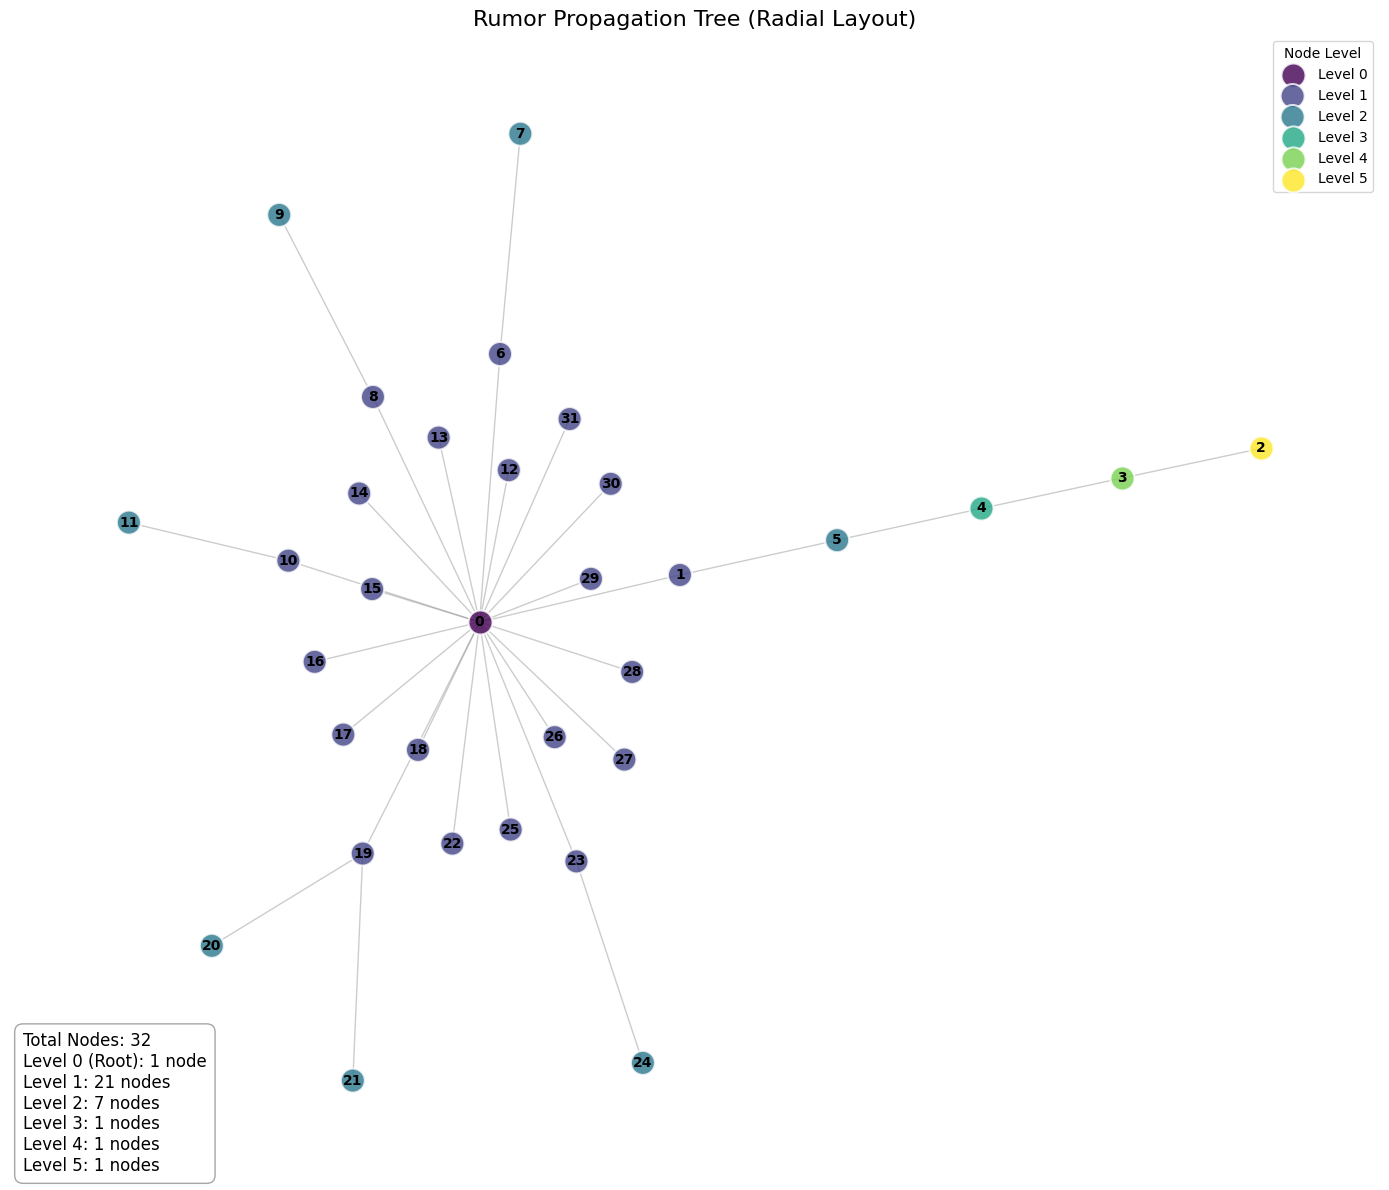

(<networkx.classes.graph.Graph at 0x7e27a9ac3dc0>,
 {0: array([-0.06613948, -0.00898157]),
  1: array([0.20717086, 0.03809495]),
  2: array([1.       , 0.1645079]),
  3: array([0.81044929, 0.13490747]),
  4: array([0.61852702, 0.10456232]),
  5: array([0.42161778, 0.07284932]),
  6: array([-0.03827336,  0.25884867]),
  7: array([-0.01052795,  0.47885803]),
  8: array([-0.2115766 ,  0.21591483]),
  9: array([-0.3394937 ,  0.39778591]),
  10: array([-0.32698806,  0.05239175]),
  11: array([-0.54455411,  0.09044096]),
  12: array([-0.02630209,  0.14280176]),
  13: array([-0.12199189,  0.17531532]),
  14: array([-0.23039106,  0.11950746]),
  15: array([-0.21271604,  0.02400732]),
  16: array([-0.29109138, -0.04866732]),
  17: array([-0.25207024, -0.12136196]),
  18: array([-0.1501756, -0.1366325]),
  19: array([-0.22550632, -0.24017315]),
  20: array([-0.43141691, -0.3323545 ]),
  21: array([-0.23904389, -0.46697824]),
  22: array([-0.10327548, -0.23023689]),
  23: array([ 0.06597579, -0.2

In [57]:
sample_data = train_dataset[22]

visualize_rumor_tree_radial(sample_data)